<a href="https://colab.research.google.com/github/EduardsLapins/Feasibility-Analysis-for-Multi-Layered-Text-to-Image-Generation-of-Comic-Strips/blob/main/Bakalaurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# recalculating all elo's because I found an image that was duplicate

import json

with open('/content/image-assets.json', 'r') as file:
    assets_data = json.load(file)

for asset in assets_data:
    asset['elo'] = 700 if asset['human'] == True else 500

with open('/content/battles.json', 'r') as file:
    battles_data = json.load(file)

def calculate_elo_change(player_elo, opponent_elo, player_score):
    k_factor = 32
    expected_score = 1 / (1 + 10 ** ((opponent_elo - player_elo) / 400))
    return k_factor * (player_score - expected_score)

elo_dict = {asset['uuid']: asset['elo'] for asset in assets_data}
for battle in battles_data:
    winner_elo = elo_dict[battle['winner']]
    loser_elo = elo_dict[battle['loser']]
    elo_change_winner = calculate_elo_change(winner_elo, loser_elo, 1)
    elo_change_loser = calculate_elo_change(loser_elo, winner_elo, 0)

    elo_dict[battle['winner']] += round(elo_change_winner)
    elo_dict[battle['loser']] += round(elo_change_loser)

for asset in assets_data:
    asset['elo'] = elo_dict[asset['uuid']]

with open('/content/image-assets.json', 'w') as file:
    json.dump(assets_data, file, indent=4)



In [4]:
# Helper functions to calculate some basic information about the data

def calculate_average_elo(image_assets):
    ai_images = [image for image in image_assets if not image['human']]
    total_elo = sum(image['elo'] for image in ai_images)
    return total_elo / len(ai_images)

def calculate_win_loss_ratio(image_assets):
    return [
        {
            'name': image['name'],
            'winLossRatio': image['wins'] / (image['losses'] or 1)
        }
        for image in image_assets
    ]

def calculate_average_user_accuracy(game_results):
    total_correct = sum(game['correct'] for game in game_results)
    total_games = sum(game['correct'] + game['wrong'] for game in game_results)
    return total_correct / total_games

def find_extremes_in_elo(image_assets):
    sorted_images = sorted(image_assets, key=lambda x: x['elo'], reverse=True)
    return {
        'highestEloImage': sorted_images[0],
        'lowestEloImage': sorted_images[-1]
    }



# **Basic statistical data about the dataset**

In [5]:
import json
import pandas as pd

with open('image-assets.json') as f:
    image_assets_data = json.load(f)

with open('gameResults.json') as f:
    game_results_data = json.load(f)

with open('battles.json') as f:
    battles = json.load(f)

image_assets_df = pd.DataFrame(image_assets_data)
game_results_df = pd.DataFrame(game_results_data)
battles_df = pd.DataFrame(battles)

# Total matches
print()
print()
total_matches = len(battles_df)
print(f'Total Matches: {total_matches}')

# Total sessions finished
print()
print()
total_sessions = len(game_results_df)
print(f'Total Sessions Finished: {total_sessions}')

# Most matches
print()
print()
sorted_by_plays = image_assets_df.sort_values(by='total_plays', ascending=False)
print("Table Sorted by Total Plays:")
print(sorted_by_plays[['name', 'total_plays']].head())
total_plays = sorted_by_plays['total_plays'].sum()
print(f'Total Plays for All Images: {total_plays}')

# Most wins
print()
print()
sorted_by_wins = image_assets_df.sort_values(by='wins', ascending=False)
print("\nTable Sorted by Most Wins:")
print(sorted_by_wins[['name', 'wins']].head())

# Most losses
print()
print()
sorted_by_losses = image_assets_df.sort_values(by='losses', ascending=False)
print("\nTable Sorted by Most Losses:")
print(sorted_by_losses[['name', 'losses']].head())

# Best win rate
print()
print()
image_assets_df['win_rate'] = image_assets_df['wins'] / image_assets_df['total_plays']
sorted_by_win_rate = image_assets_df.sort_values(by='win_rate', ascending=False)
print("\nTable Sorted by Win Rate:")
print(sorted_by_win_rate[['name', 'win_rate']].head())

# Combined
# combined_sorted_table = image_assets_df.sort_values(by=['total_plays', 'wins', 'losses', 'win_rate'], ascending=False)
# print("\nTable Sorted by Plays, Wins, Losses, and Win Rate:")
# print(combined_sorted_table[['name', 'total_plays', 'wins', 'losses', 'win_rate']].head())

# Average Elo's
print()
print()
average_elo_human = image_assets_df[image_assets_df['human'] == True]['elo'].mean()
average_elo_ai = image_assets_df[image_assets_df['human'] == False]['elo'].mean()
print(f'Average Elo for Humans: {average_elo_human:.2f}')
print(f'Average Elo for AI: {average_elo_ai:.2f}')







Total Matches: 1018


Total Sessions Finished: 70


Table Sorted by Total Plays:
                                                  name  total_plays
100                               bullet hits wall.png           56
64   latvian singers making forests shine with thei...           42
106                                   falling lamp.png           41
36                       a plant grows from a boot.png           40
84     a photographer taking a picture of a sunset.png           39
Total Plays for All Images: 2062



Table Sorted by Most Wins:
                                                  name  wins
100                               bullet hits wall.png    46
106                                   falling lamp.png    38
108                                          sonic.png    31
36                       a plant grows from a boot.png    31
64   latvian singers making forests shine with thei...    28



Table Sorted by Most Losses:
                                                

# **Histogram of Elo distribution**

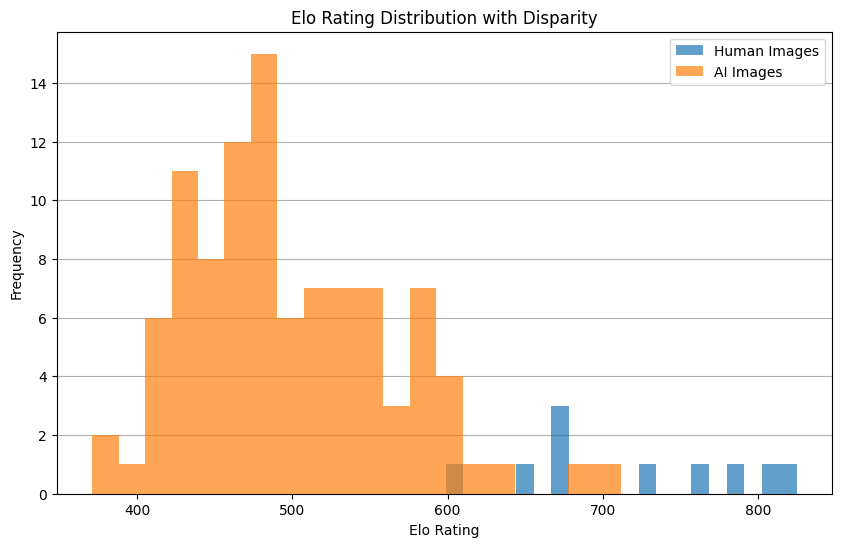

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.grid(axis='y', zorder=0)
plt.hist(image_assets_df[image_assets_df['human'] == True]['elo'], bins=20, alpha=0.7, label='Human Images', zorder=3)
plt.hist(image_assets_df[image_assets_df['human'] == False]['elo'], bins=20, alpha=0.7, label='AI Images', zorder=3)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution with Disparity')
plt.legend()
plt.show()


# **Best performers**

In [7]:
# Best performers
# Human
best_human_images = image_assets_df[image_assets_df['human'] == True].sort_values(by='elo', ascending=False).head(5)
print("Top 5 Best Performing Human Images:")
print(best_human_images[['name', 'elo']])


# AI
print()
print()
best_ai_images = image_assets_df[image_assets_df['human'] == False].sort_values(by='elo', ascending=False).head(5)
print("\nTop 5 Best Performing AI Images:")
print(best_ai_images[['name', 'elo']])


# Worst performers
# Human
print()
print()
worst_human_images = image_assets_df[image_assets_df['human'] == True].sort_values(by='elo').head(5)
print("\nTop 5 Worst Performing Human Images:")
print(worst_human_images[['name', 'elo']])


# AI
print()
print()
worst_ai_images = image_assets_df[image_assets_df['human'] == False].sort_values(by='elo').head(5)
print("\nTop 5 Worst Performing AI Images:")
print(worst_ai_images[['name', 'elo']])

Top 5 Best Performing Human Images:
                     name  elo
106      falling lamp.png  825
105          work day.png  806
100  bullet hits wall.png  790
108             sonic.png  765
107              burp.png  732



Top 5 Best Performing AI Images:
                                                 name  elo
84    a photographer taking a picture of a sunset.png  712
36                      a plant grows from a boot.png  681
75     square figure meets a triangle and says hi.png  636
86  a toy soldier playing accordion and his mates ...  613
99  a couple spending a beautiful night on a beach...  608



Top 5 Worst Performing Human Images:
                               name  elo
104  lovers run into each other.png  599
109                      shroom.png  646
103             march to battle.png  668
101        medieval sword shock.png  669
102                    nun slap.png  670



Top 5 Worst Performing AI Images:
                                                 name  elo
8   to

# **User session statistics**

In [8]:
# User session results


total_correct = game_results_df['correct'].sum()
total_incorrect = game_results_df['wrong'].sum()

# Calculate user accuracy
user_accuracy = total_correct / (total_correct + total_incorrect)

print(f'User Accuracy: {user_accuracy:.5f}')
print(f'Total Correct Guesses: {total_correct}')
print(f'Total Incorrect Guesses: {total_incorrect}')


User Accuracy: 0.35811
Total Correct Guesses: 53
Total Incorrect Guesses: 95


# **Recalculating the data, with no Elo disparity**

In [9]:
# Simulating the Elo, if it was equal for all images from the start

initial_elo = 500
elo_ratings = {image['uuid']: initial_elo for image in image_assets_data}

def calculate_elo(winner_uuid, loser_uuid, elo_ratings, k_factor=32):
    winner_elo = elo_ratings[winner_uuid]
    loser_elo = elo_ratings[loser_uuid]

    expected_score_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    expected_score_loser = 1 - expected_score_winner

    winner_change = round(k_factor * (1 - expected_score_winner))
    loser_change = round(k_factor * (0 - expected_score_loser))

    elo_ratings[winner_uuid] += winner_change
    elo_ratings[loser_uuid] += loser_change

for battle in battles:
    calculate_elo(battle['winner'], battle['loser'], elo_ratings)


for image in image_assets_data:
    image['new_elo'] = elo_ratings[image['uuid']]


sorted_images_new_elo = sorted(image_assets_data, key=lambda x: x['new_elo'], reverse=True)


print("Top 5 Images Based on New Elo Ratings:")
for image in sorted_images_new_elo[:5]:
    print(f"{image['name']} - New Elo: {image['new_elo']}")


Top 5 Images Based on New Elo Ratings:
falling lamp.png - New Elo: 754
bullet hits wall.png - New Elo: 749
work day.png - New Elo: 720
sonic.png - New Elo: 703
a photographer taking a picture of a sunset.png - New Elo: 695


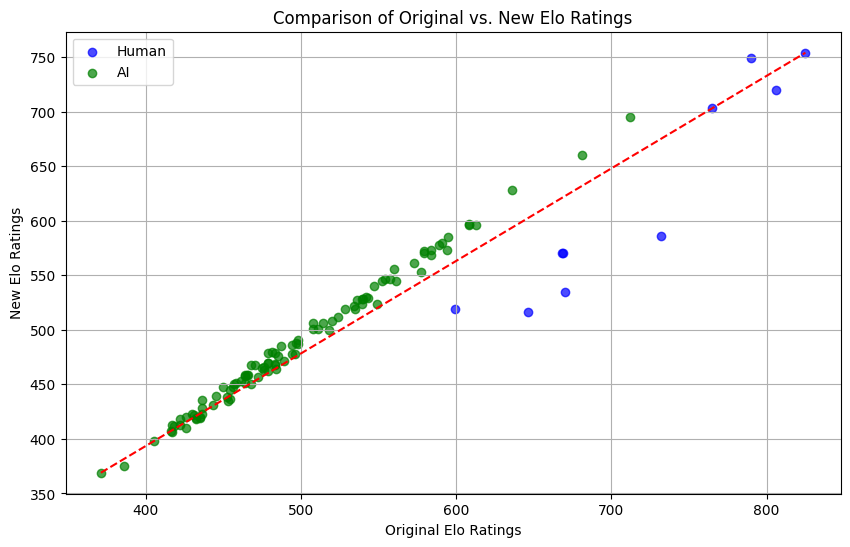

In [10]:
import matplotlib.pyplot as plt

human_images = [image for image in image_assets_data if image['human']]
ai_images = [image for image in image_assets_data if not image['human']]

original_elos_human = [image['elo'] for image in human_images]
new_elos_human = [image['new_elo'] for image in human_images]

original_elos_ai = [image['elo'] for image in ai_images]
new_elos_ai = [image['new_elo'] for image in ai_images]

plt.figure(figsize=(10, 6))
plt.scatter(original_elos_human, new_elos_human, alpha=0.7, color='blue', label='Human')
plt.scatter(original_elos_ai, new_elos_ai, alpha=0.7, color='green', label='AI')
plt.title('Comparison of Original vs. New Elo Ratings')
plt.xlabel('Original Elo Ratings')
plt.ylabel('New Elo Ratings')
plt.grid(True)
plt.legend()
plt.plot([min(original_elos_human + original_elos_ai), max(original_elos_human + original_elos_ai)], [min(new_elos_human + new_elos_ai), max(new_elos_human + new_elos_ai)], color='red', linestyle='--')  # Line y=x for reference
plt.show()



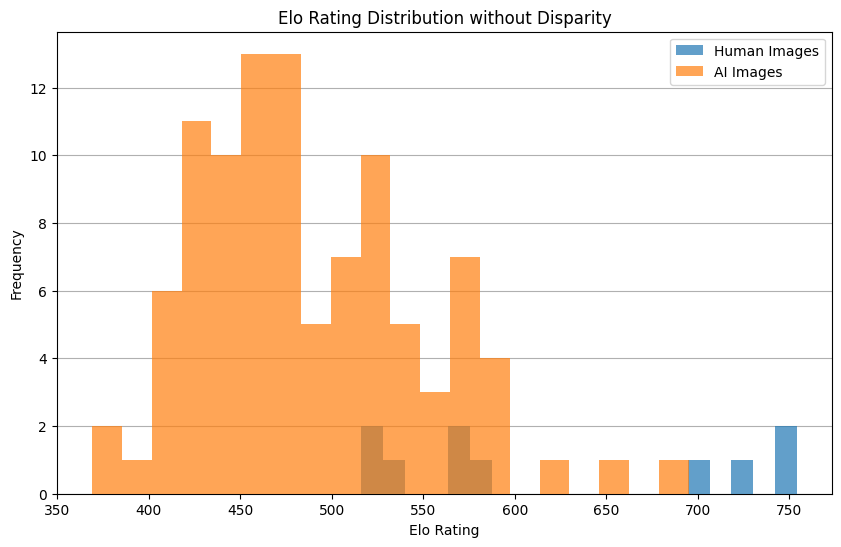

In [11]:
import matplotlib.pyplot as plt

image_assets_df['new_elo'] = [image['new_elo'] for image in image_assets_data]

plt.figure(figsize=(10,6))
plt.grid(axis='y', zorder=0)
plt.hist(image_assets_df[image_assets_df['human'] == True]['new_elo'], bins=20, alpha=0.7, label='Human Images', zorder=3)
plt.hist(image_assets_df[image_assets_df['human'] == False]['new_elo'], bins=20, alpha=0.7, label='AI Images', zorder=3)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution without Disparity')
plt.legend()
plt.show()

In [12]:
# Best performers
# Human
best_human_images = image_assets_df[image_assets_df['human'] == True].sort_values(by='new_elo', ascending=False).head(5)
print("Top 5 Best Performing Human Images:")
print(best_human_images[['name', 'new_elo']])


# AI
print()
print()
best_ai_images = image_assets_df[image_assets_df['human'] == False].sort_values(by='new_elo', ascending=False).head(5)
print("\nTop 5 Best Performing AI Images:")
print(best_ai_images[['name', 'new_elo']])


# Worst performers
# Human
print()
print()
worst_human_images = image_assets_df[image_assets_df['human'] == True].sort_values(by='new_elo').head(5)
print("\nTop 5 Worst Performing Human Images:")
print(worst_human_images[['name', 'new_elo']])


# AI
print()
print()
worst_ai_images = image_assets_df[image_assets_df['human'] == False].sort_values(by='new_elo').head(5)
print("\nTop 5 Worst Performing AI Images:")
print(worst_ai_images[['name', 'new_elo']])


# Average Elo's
print()
print()
average_elo_human = image_assets_df[image_assets_df['human'] == True]['new_elo'].mean()
average_elo_ai = image_assets_df[image_assets_df['human'] == False]['new_elo'].mean()
print(f'Average Elo for Humans: {average_elo_human:.2f}')
print(f'Average Elo for AI: {average_elo_ai:.2f}')

Top 5 Best Performing Human Images:
                     name  new_elo
106      falling lamp.png      754
100  bullet hits wall.png      749
105          work day.png      720
108             sonic.png      703
107              burp.png      586



Top 5 Best Performing AI Images:
                                                 name  new_elo
84    a photographer taking a picture of a sunset.png      695
36                      a plant grows from a boot.png      660
75     square figure meets a triangle and says hi.png      628
99  a couple spending a beautiful night on a beach...      597
86  a toy soldier playing accordion and his mates ...      596



Top 5 Worst Performing Human Images:
                               name  new_elo
109                      shroom.png      516
104  lovers run into each other.png      519
102                    nun slap.png      535
101        medieval sword shock.png      570
103             march to battle.png      570



Top 5 Worst Performing AI I

In [13]:
best = image_assets_df.sort_values(by='new_elo', ascending=False)
selected_columns = best[['name', 'uuid', 'human', 'elo', 'new_elo', 'beat_ai', 'beat_human', 'lost_to_ai', 'lost_to_human', 'losses', 'wins', 'total_plays']]
print("Top 5 Best Performing Images:")
print(selected_columns)



Top 5 Best Performing Images:
                                                  name              uuid  \
106                                   falling lamp.png  wqBvlF9VzCZfW9Pv   
100                               bullet hits wall.png  zDSkNCJWjuAciex7   
105                                       work day.png  8pOvfI0dgghYW6HY   
108                                          sonic.png  dPPgNzFEONnh814G   
84     a photographer taking a picture of a sunset.png  EVz4L7f9IORgTaEh   
..                                                 ...               ...   
67   mercedes benz, audi and bmw arguing about whic...  5RXdhFqA8xM7qJvS   
60                cowboy shooting at glass bottles.png  Hd6JOJMNRNOJtrkv   
59                     comic on how earth was born.png  2P99CxbqAsXirau8   
70               polandball argues with swedenball.png  SSxYNgBx0IIQQH39   
8    toy soldiers fighting in the battle of the ard...  UOLjuJtH2gcH1wqY   

     human  elo  new_elo  beat_ai  beat_human  lost_to_ai

In [ ]:
selected_columns.to_excel('top_performing_images.xlsx', index=False)

In [16]:
image_assets_df.to_json('/content/image-assets-new.json', orient='records', lines=True, indent=4)

# **Trying to find something statistically significant**

In [ ]:
from scipy.stats import binomtest

# Analysing the user ability to confidently discern human and AI works

total_correct = game_results_df['correct'].sum()
total_guesses = total_correct + game_results_df['wrong'].sum()

p_value = binomtest(total_correct, total_guesses, p=0.5)
print(f'Binomial test p-value: {p_value}')


Binomial test p-value: BinomTestResult(k=53, n=148, alternative='two-sided', statistic=0.3581081081081081, pvalue=0.0006979143875100888)


In [ ]:
from scipy.stats import ttest_ind

# Seeing if there is strong indication that human works are clearly different from AI

elo_ai = image_assets_df[image_assets_df['human'] == False]['new_elo']
elo_human = image_assets_df[image_assets_df['human'] == True]['new_elo']

t_stat, p_value = ttest_ind(elo_ai, elo_human, equal_var=False)
print(f'T-test p-value: {p_value}')


T-test p-value: 0.0017432565897531045


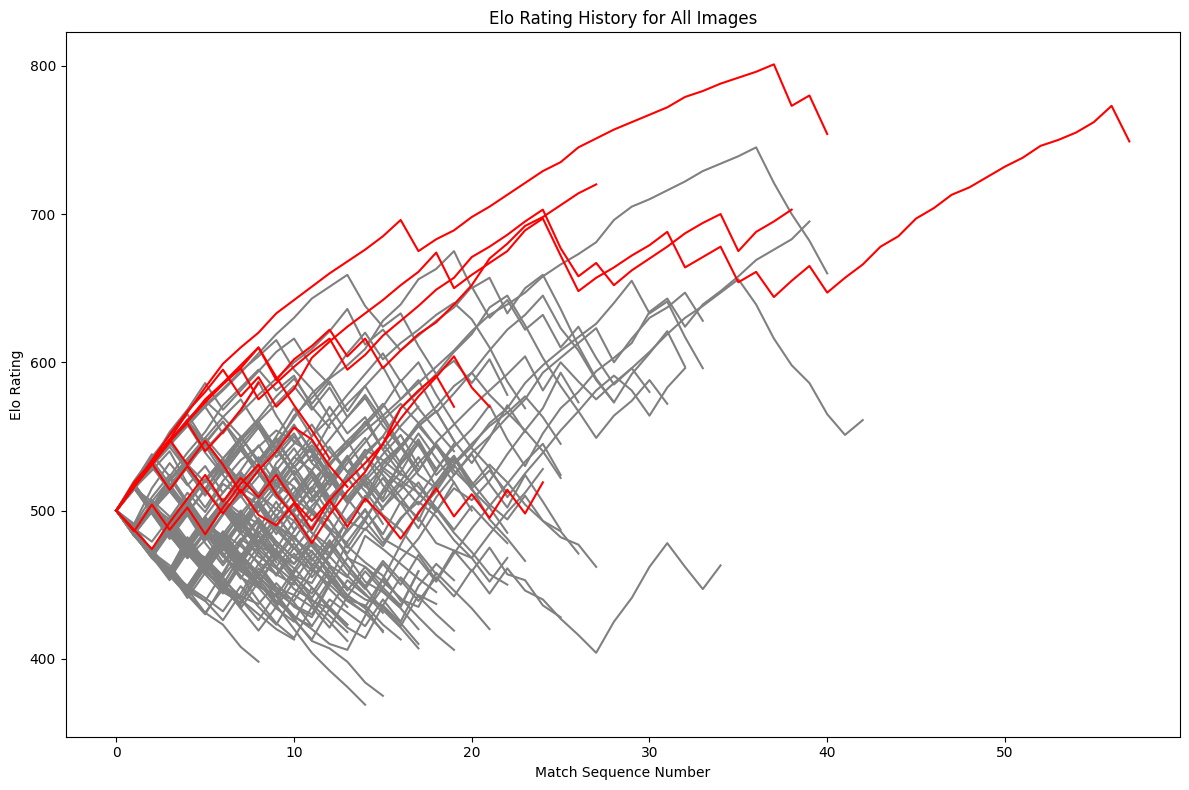

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


def calculate_elo_change(winner_elo, loser_elo, k_factor=32):
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    expected_loser = 1 - expected_winner
    winner_change = round(k_factor * (1 - expected_winner))
    loser_change = round(k_factor * (0 - expected_loser))
    return winner_change, loser_change


initial_elo = 500
elo_ratings = {uuid: [initial_elo] for uuid in image_assets_df['uuid']}


for _, row in battles_df.iterrows():
    winner_uuid = row['winner']
    loser_uuid = row['loser']
    winner_elo = elo_ratings[winner_uuid][-1]
    loser_elo = elo_ratings[loser_uuid][-1]

    winner_change, loser_change = calculate_elo_change(winner_elo, loser_elo)
    new_winner_elo = winner_elo + winner_change
    new_loser_elo = loser_elo + loser_change

    elo_ratings[winner_uuid].append(new_winner_elo)
    elo_ratings[loser_uuid].append(new_loser_elo)


for image in image_assets_df.to_dict('records'):
    elo_ratings[image['uuid']].append('human' if image['human'] else 'ai')


plt.figure(figsize=(12, 8))
for uuid, history in elo_ratings.items():
    image_type = history.pop()
    color = 'red' if image_type == 'human' else 'gray'
    plt.plot(range(len(history)), history, color=color)

plt.xlabel('Match Sequence Number')
plt.ylabel('Elo Rating')
plt.title('Elo Rating History for All Images')
plt.tight_layout()
plt.show()


In [ ]:
# Finding how many AI comics fit within the human Elo range

human_elo_ratings = image_assets_df[image_assets_df['human'] == True]['new_elo']
min_human_elo = human_elo_ratings.min()
max_human_elo = human_elo_ratings.max()


ai_elo_ratings = image_assets_df[image_assets_df['human'] == False]['new_elo']
ai_comics_in_human_range = ai_elo_ratings[(ai_elo_ratings >= min_human_elo) & (ai_elo_ratings <= max_human_elo)].count()


total_ai_comics = ai_elo_ratings.count()
percentage_ai_in_human_range = (ai_comics_in_human_range / total_ai_comics) * 100
print(f"Percentage of AI comics within human Elo rating range: {percentage_ai_in_human_range:.2f}%")


Percentage of AI comics within human Elo rating range: 32.00%


In [ ]:
# Finding how many AI comics fit within the human Elo range (with disparity)

human_elo_ratings = image_assets_df[image_assets_df['human'] == True]['elo']
min_human_elo = human_elo_ratings.min()
max_human_elo = human_elo_ratings.max()


ai_elo_ratings = image_assets_df[image_assets_df['human'] == False]['elo']
ai_comics_in_human_range = ai_elo_ratings[(ai_elo_ratings >= min_human_elo) & (ai_elo_ratings <= max_human_elo)].count()


total_ai_comics = ai_elo_ratings.count()
percentage_ai_in_human_range = (ai_comics_in_human_range / total_ai_comics) * 100
print(f"Percentage of AI comics within human Elo rating range: {percentage_ai_in_human_range:.2f}%")

Percentage of AI comics within human Elo rating range: 6.00%


# **Trying to get YOLO working**

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


--2024-04-02 22:34:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  25.1MB/s    in 10s     

2024-04-02 22:34:44 (23.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-04-02 22:34:44--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

In [ ]:

def decode_predictions(scores, geometry, min_confidence=0.5):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []


    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):

            if scoresData[x] < min_confidence:
                continue


            (offsetX, offsetY) = (x * 4.0, y * 4.0)


            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)


            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]


            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)


            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])


    return (rects, confidences)


In [ ]:

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):

    if len(boxes) == 0:
        return []


    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")


    pick = []


    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]


    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)


    while len(idxs) > 0:

        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])


        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)


        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")


--2024-04-04 02:20:09--  https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb [following]
--2024-04-04 02:20:09--  https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96662756 (92M) [application/octet-stream]
Saving to: ‘frozen_east_text_detection.pb.4’

frozen_east_text_de 100%[===================>]  92.18M   202MB/s    in 0.5s    

20

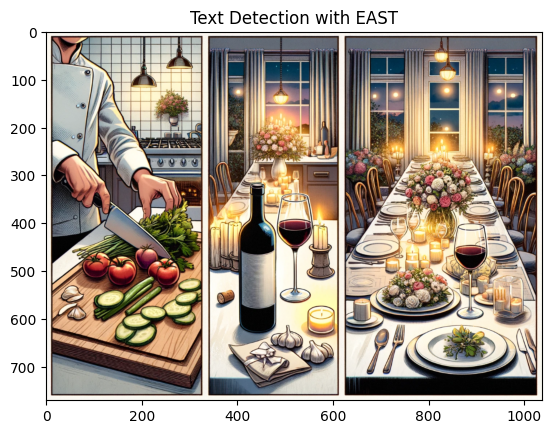

In [ ]:
!wget https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb

import cv2
import numpy as np
from matplotlib import pyplot as plt

def detect_text_east(image_path, min_confidence=0.5, width=320, height=320):
    image = cv2.imread(image_path)
    orig = image.copy()
    orig_height, orig_width = image.shape[:2]

    rW = orig_width / float(width)
    rH = orig_height / float(height)

    image = cv2.resize(image, (width, height))
    (H, W) = image.shape[:2]

    layer_names = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    net = cv2.dnn.readNet('frozen_east_text_detection.pb')
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layer_names)

    (rects, confidences) = decode_predictions(scores, geometry, min_confidence)

    boxes = non_max_suppression(np.array(rects), probs=confidences)

    filtered_boxes = []
    for (startX, startY, endX, endY) in boxes:

        size = (endX - startX) * (endY - startY)
        if 100 < size < 1000:
            filtered_boxes.append((startX, startY, endX, endY))


    for (startX, startY, endX, endY) in filtered_boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title('Text Detection with EAST')
    plt.show()

    return filtered_boxes

text_boxes = detect_text_east('/content/without_text/AI/a beautiful romantic dinner being prepared.png', min_confidence=0.9)


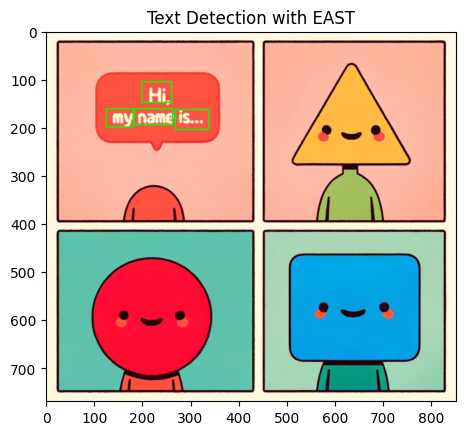

In [ ]:
text_boxes = detect_text_east('/content/dall-e/a circle in frame 1, a square in frame 2, and a triangle in frame 3 all say hi, my name is.png', min_confidence=0.9)


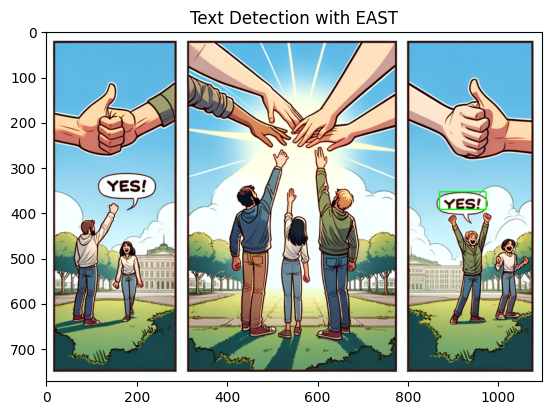

In [ ]:
text_boxes = detect_text_east('/content/dall-e/3 friends putting hands together and saying YES.png', min_confidence=0.9)


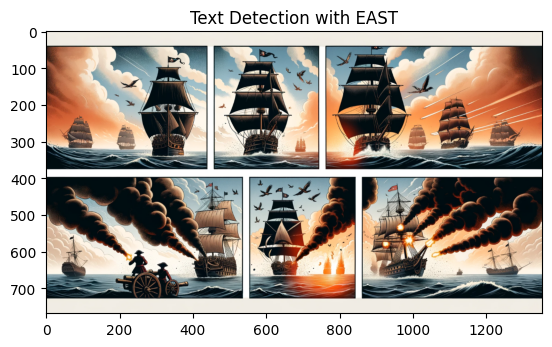

In [ ]:
text_boxes = detect_text_east('/content/dall-e/a battle of a pirate ship with a british frigate.png')


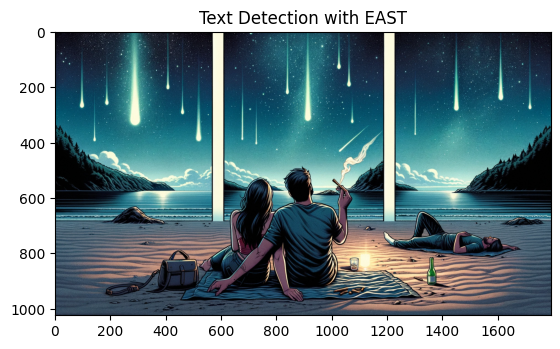

In [ ]:
text_boxes = detect_text_east('/content/dall-e/a couple spending a beautiful night on a beach watching meteor showers and smoking a blunt 169.webp', min_confidence=0.9)

In [ ]:
import os
import shutil

source_dir = '/content/dall-e'
source_dir2 = '/content/real_art'

text_dir = '/content/with_text'
no_text_dir = '/content/without_text'


if not os.path.exists(text_dir):
    os.makedirs(text_dir)

if not os.path.exists(no_text_dir):
    os.makedirs(no_text_dir)


In [ ]:
from PIL import Image

for filename in os.listdir(source_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        print(f"Processing {filename}...")
        file_path = os.path.join(source_dir, filename)

        try:
            text_boxes = detect_text_east(file_path, min_confidence=0.95)

            if text_boxes:
                shutil.copy(file_path, os.path.join(text_dir, filename))
            else:
                shutil.copy(file_path, os.path.join(no_text_dir, filename))

        except Exception as e:
            print(f"An error occurred with {filename}: {e}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/dall-e'

In [ ]:
import shutil
from google.colab import files

shutil.make_archive('/content/with_text', 'zip', text_dir)
shutil.make_archive('/content/without_text', 'zip', no_text_dir)

files.download('/content/with_text.zip')
files.download('/content/without_text.zip')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
import os


text_ai_dir = '/content/with_text/AI'
text_human_dir = '/content/with_text/Human'
no_text_ai_dir = '/content/without_text/AI'
no_text_human_dir = '/content/without_text/Human'

text_ai_files = os.listdir(text_ai_dir)
text_human_files = os.listdir(text_human_dir)
no_text_ai_files = os.listdir(no_text_ai_dir)
no_text_human_files = os.listdir(no_text_human_dir)

with open('/content/image-assets.json', 'r') as file:
    data = json.load(file)

for entry in data:
    filename = entry['name']
    if filename in text_ai_files or filename in text_human_files:
        entry['text'] = True
    elif filename in no_text_ai_files or filename in no_text_human_files:
        entry['text'] = False


with open('/content/image-assets.json', 'w') as file:
    json.dump(data, file, indent=4)



## **Analysing comic performance based on whether they have text in them**

In [ ]:
import os
import json

ai_folder_path = '/content/with_text/AI'
human_folder_path = '/content/with_text/Human'
no_text_ai_dir = '/content/without_text/AI'
no_text_human_dir = '/content/without_text/Human'
folders_paths = [ai_folder_path, human_folder_path, no_text_ai_dir, no_text_human_dir]


i = 0
folder_images = set()
for folder_path in folders_paths:
    i = 0
    print(folder_path)
    for filename in os.listdir(folder_path):
      i += 1
      folder_images.add(filename)

    print(i)


# for image in folder_images:
#   print(image)


with open('/content/image-assets.json', 'r') as file:
    json_data = json.load(file)
json_images = set(item['name'] for item in json_data)
# print("++++++++++++++++++")
# for item in json_data:
#   print(item['name'])

json_not_in_folders = json_images - folder_images
folders_not_in_json = folder_images - json_images

print(json_images)
print(folder_images)

print("Images in JSON but not in folders:", json_not_in_folders)
print("Images in folders but not in JSON:", folders_not_in_json)
print(len(json_images))
print(len(folder_images))



/content/with_text/AI
0
/content/with_text/Human
0
/content/without_text/AI
0
/content/without_text/Human
0
{'a simple image of a mercedes sedan strewn accros all 3 panels, with the phrase excellence.png', 'water bottles being recycled (2).png', 'work day.png', 'americans being confused about the metric system.png', 'a phone battery dies.png', 'moon colliding with earth.png', 'march to battle.png', 'comic about climate change getting worse.png', 'comic about surviving a tough workday with cool stylized text.webp', 'a tutorial for drawing a stickman.png', 'a hiking group reaches a mountain peak.png', 'a food fight in a high school.png', 'if a tree falls in a forest and no one is there to hear it, did it make a sound.png', 'latvian singers making forests shine with their song.png', 'a group of friends making coffee.png', 'cube people in a cube world making little villages.png', 'a zebra and a lion running through the jungles of madagascar together.png', 'a boy learns to ride a bike.png',

In [ ]:
import json
import pandas as pd

with open('/content/image-assets.json', 'r') as file:
    data = json.load(file)

df = image_assets_df

text_count = df[df['text'] == True].count()['name']
no_text_count = df[df['text'] == False].count()['name']
print(f"There are {text_count} images with text and {no_text_count} images without text.")

if 'new_elo' in df.columns:
    avg_elo_with_text = df[df['text'] == True]['new_elo'].mean()
    avg_elo_no_text = df[df['text'] == False]['new_elo'].mean()
    print(f"The average Elo rating for images with text is {avg_elo_with_text:.2f}")
    print(f"The average Elo rating for images without text is {avg_elo_no_text:.2f}")

if 'style' in df.columns:
    style_counts_with_text = df[df['text'] == True]['style'].value_counts()
    style_counts_no_text = df[df['text'] == False]['style'].value_counts()
    print("Style counts for images with text:")
    print(style_counts_with_text)
    print("Style counts for images without text:")
    print(style_counts_no_text)

if 'user_selection' in df.columns:
    user_pref_with_text = df[df['text'] == True]['user_selection'].value_counts(normalize=True)
    user_pref_no_text = df[df['text'] == False]['user_selection'].value_counts(normalize=True)
    print("User selection percentage for images with text:")
    print(user_pref_with_text)
    print("User selection percentage for images without text:")
    print(user_pref_no_text)


There are 55 images with text and 55 images without text.
The average Elo rating for images with text is 488.96
The average Elo rating for images without text is 511.04


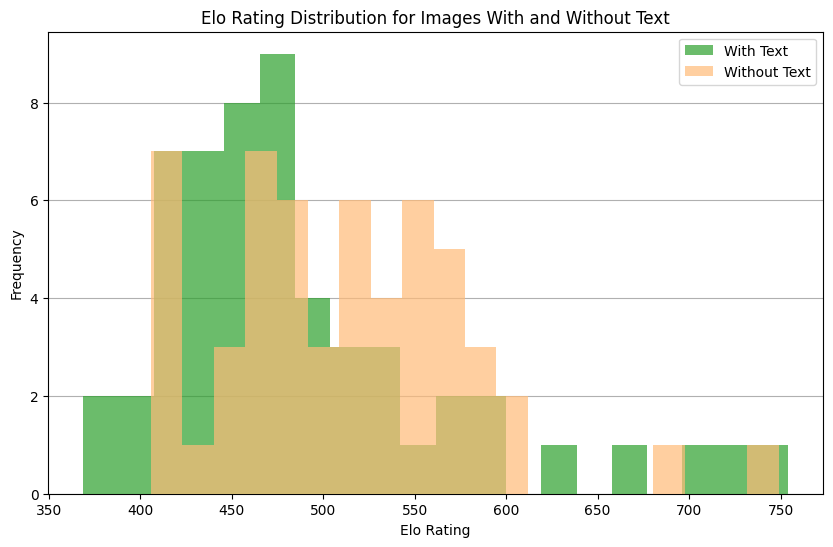

In [ ]:
import matplotlib.pyplot as plt

df_with_text = df[df['text'] == True]
df_no_text = df[df['text'] == False]


plt.figure(figsize=(10, 6))
plt.grid(axis="y", zorder=0)
plt.hist(df_with_text['new_elo'], bins=20, alpha=0.7, label='With Text', color='#2ca02c', zorder=3)
plt.hist(df_no_text['new_elo'], bins=20, alpha=0.7, label='Without Text', color='#ffbb78', zorder=3)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution for Images With and Without Text')
plt.legend()
plt.show()


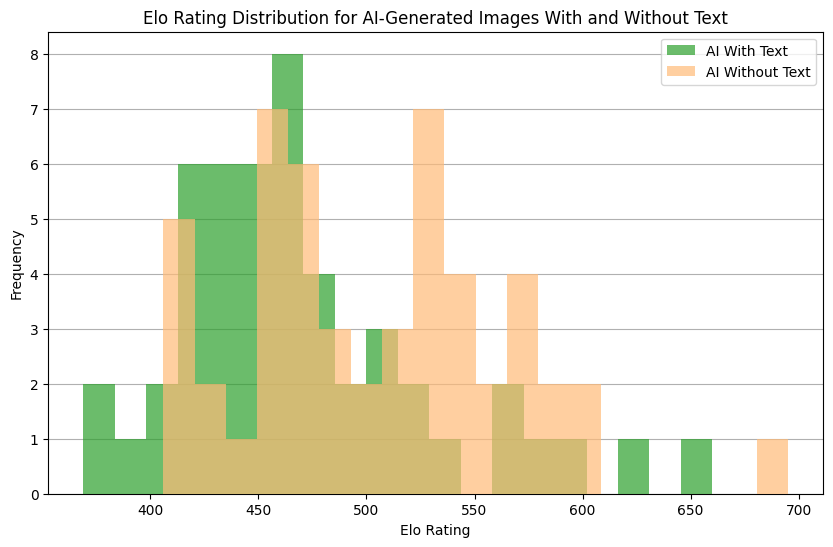

In [ ]:
df_ai = df[df['human'] == False]

df_ai_with_text = df_ai[df_ai['text'] == True]
df_ai_no_text = df_ai[df_ai['text'] == False]

plt.figure(figsize=(10, 6))
plt.grid(axis="y", zorder=0)
plt.hist(df_ai_with_text['new_elo'], bins=20, alpha=0.7, label='AI With Text', color='#2ca02c', zorder=3)
plt.hist(df_ai_no_text['new_elo'], bins=20, alpha=0.7, label='AI Without Text', color='#ffbb78', zorder=3)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution for AI-Generated Images With and Without Text')
plt.legend()
plt.show()


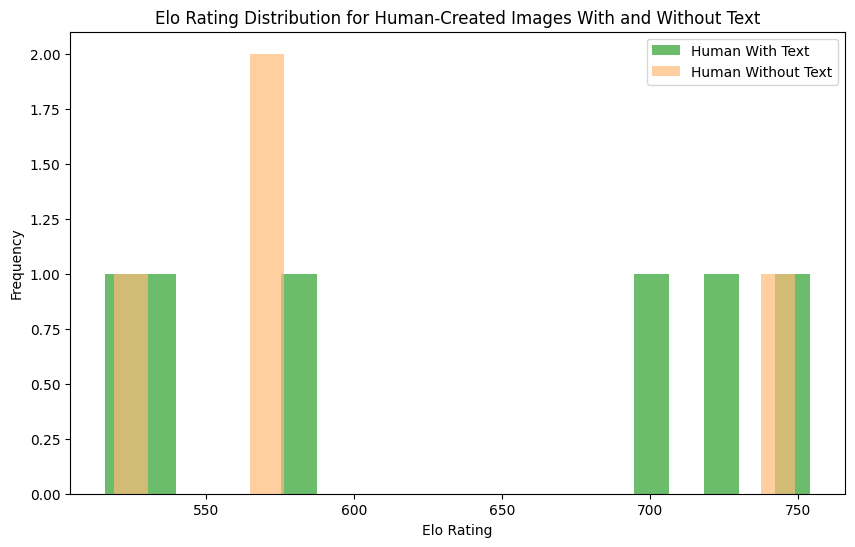

In [ ]:
df_ai = df[df['human'] == True]

df_ai_with_text = df_ai[df_ai['text'] == True]
df_ai_no_text = df_ai[df_ai['text'] == False]

plt.figure(figsize=(10, 6))
plt.hist(df_ai_with_text['new_elo'], bins=20, alpha=0.7, color='#2ca02c', label='Human With Text')
plt.hist(df_ai_no_text['new_elo'], bins=20, alpha=0.7, color='#ffbb78', label='Human Without Text')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution for Human-Created Images With and Without Text')
plt.legend()
plt.show()

In [ ]:
from scipy import stats

df_ai = df[df['human'] == False]

df_ai_with_text = df_ai[df_ai['text'] == True]
df_ai_no_text = df_ai[df_ai['text'] == False]

t_stat, p_value = stats.ttest_ind(df_ai_with_text['new_elo'], df_ai_no_text['new_elo'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference in Elo ratings between AI-generated images with and without text is statistically significant.")
else:
    print("There is no statistically significant difference in Elo ratings between AI-generated images with and without text.")


T-statistic: -2.705616262890893
P-value: 0.008041821032034688
The difference in Elo ratings between AI-generated images with and without text is statistically significant.


In [ ]:
import json
import pandas as pd

with open('image-assets.json') as f:
    image_assets_data = json.load(f)

image_assets_df = pd.DataFrame(image_assets_data)

average_elo_text = df_ai[df_ai['text'] == True]['new_elo'].mean()
average_elo_notext = df_ai[df_ai['text'] == False]['new_elo'].mean()
print(f'Average Elo for Humans: {average_elo_text:.2f}')
print(f'Average Elo for AI: {average_elo_notext:.2f}')

Average Elo for Humans: 471.00
Average Elo for AI: 503.90


In [ ]:
df_ai = df[df['human'] == True]

df_ai_with_text = df_ai[df_ai['text'] == True]
df_ai_no_text = df_ai[df_ai['text'] == False]

t_stat, p_value = stats.ttest_ind(df_ai_with_text['new_elo'], df_ai_no_text['new_elo'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference in Elo ratings between Human-Created images with and without text is statistically significant.")
else:
    print("There is no statistically significant difference in Elo ratings between Human-Created images with and without text.")


T-statistic: 0.5116938036711399
P-value: 0.6226868537961668
There is no statistically significant difference in Elo ratings between Human-Created images with and without text.
